In [2]:
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import os
from sys import float_info
import scipy.constants as constants
from matplotlib.ticker import FormatStrFormatter
print('finished import')

finished import


In [23]:
# Find data files
#--------------------------------------------------------

path = 'processed'
export_path='exports'

# glob processed files
temperatures = glob.glob(path)
data_files = glob.glob('processed/***.txt')

# Funciton definitions
#--------------------------------------------------------

#   Gaussian formula
def gaussian(x, A, x0, sig):
    return A*np.exp(-(x-x0)**2/(2*sig**2))

def multi_gaussian(x, *pars):
    g1 = gaussian(x, pars[0], pars[1], pars[2])
    g2 = gaussian(x, pars[3], pars[4], pars[5])
    g3 = gaussian(x, pars[6], pars[7], pars[8])
    g4 = gaussian(x, pars[9], pars[10], pars[11])
    # return g1 + g2 + g3 
    return g1 + g2 + g3 + g4

# Converting wavelength (nm) to energy (eV)
# Function to prevent zero values in an array
def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if abs(entry) < float_info.epsilon:
            corrected_array[i] = float_info.epsilon
    
    return corrected_array

def WLtoE(wl):
    # Prevent division by zero error
    #wl = preventDivisionByZero(wl)

    # E = h*c/wl            
    h = constants.h         # Planck constant
    c = constants.c         # Speed of light
    J_eV = constants.e      # Joule-electronvolt relationship
    
    wl_nm = wl * 10**(-9)   # convert wl from nm to m
    E_J = (h*c) / wl_nm     # energy in units of J
    E_eV = E_J / J_eV       # energy in units of eV
    
    return E_eV  

def PlotGaussFit(name, x, data, fit, residuals_4gauss, gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4):
    
    ###
    
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]})
    fig.subplots_adjust(hspace=0) # Remove horizontal space between axes

    fig.suptitle('fit data with 4 Gaussians'+name, family="serif", fontsize=12)
    plt.xlabel('wavelength / eV', family="serif", fontsize=12)

    axs[1].plot(x,residuals_4gauss,'go:',label='res')

    axs[1].set_ylabel("residuals",family="serif", fontsize=12)  
    axs[0].plot(x,data,'b+:',label='data')

    axs[0].plot(x, gauss_peak_1, "g")
    axs[0].fill_between(x, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)

    axs[0].set_ylabel("absorbance",family="serif", fontsize=12)    
    axs[0].plot(x,  gauss_peak_2, "y")
    axs[0].fill_between(x, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

    axs[0].plot(x,  gauss_peak_3, "m")
    axs[0].fill_between(x, gauss_peak_3.min(), gauss_peak_3, facecolor="magenta", alpha=0.5)  

    axs[0].plot(x,  gauss_peak_4, "k")
    axs[0].fill_between(x, gauss_peak_4.min(), gauss_peak_4, facecolor="k", alpha=0.5)  
    
    axs[0].plot(x,  fit, "-k", label = 'Gaussian fit')

    #axs[0].annotate(residuals, xy =(150, max(df['absorbance_bk'])))
    #axs[0].text(0,0.7,'pars_4'+str(pars_4),transform=axs[0].transAxes)
    #axs[0].text(0,0.6,'pars_3'+str(pars_3),transform=axs[0].transAxes)
    #axs[0].text(0,0.5,'pars_2'+str(pars_2),transform=axs[0].transAxes)
    #axs[0].text(0,0.4,'pars_1'+str(pars_1),transform=axs[0].transAxes)

    axs[1].legend()
    axs[0].legend()


#   initial guess with bounds for eV fit
init_vals = [0.2, 8.6,0.38,
         0.05, 8.4, 0.172,
         0.3, 10.830, 1.22,
         0.05, 6.5, 0.174]

bounds_min = [0.01,8.0,0.37, # 8 eV peak
              0.01,7.2,0.1, # 7 eV peak
              0,10.8,1.2, # high energy background peak
              0,6.45,0] # low energy peak

bounds_max = [1.2,8.9,0.4,
              0.4,8.5,0.3,
              1.3,10.9,1.23,
              0.05,6.55,0.25]

#   create lists for data, temp & deposition
data_dict=[]
temp = []
depo = []

#   Load files and fit
#--------------------------------------------------------

for i in data_files:
    
    #   find temperature from data file name
    temperature = int(i[16:19])
    
    #   adjust for file naming - i.e. add  0.5 K to 127.5 and 137.5 K
    temperature = np.where((temperature==127 or temperature==137) , temperature+0.5, temperature)
    
    #   load data in datafram
    df = pd.read_csv(i, delimiter=' ', names=['wavelength', 'absorbance'])
       
    #   find data file name
    name = i[16:-4]
    #   find deposition number from file name
    d = i.find('dep')
    deposition = int(i[d+3])

    #   discard data below 117 nm and above 220 nm
    df = df.drop(df[df['wavelength']<117].index)

    #   set a linear background by finding the minimum point on the curve and drawing a linear line here
    linear_BkGd=df['absorbance'].min()
    #   substract bkg
    y = df['absorbance_bk'] = df['absorbance'] - linear_BkGd  
    
    # #make shorthand for wavelength
    x = WLtoE(df['wavelength'])

    #   fit Gaussian
    popt, pcov = curve_fit(multi_gaussian, x, df['absorbance_bk'], p0=init_vals, bounds=(bounds_min,bounds_max))
    
    perr_3gauss = np.sqrt(np.diag(pcov))

    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    pars_3 = popt[6:9]
    pars_4 = popt[9:12]
    gauss_peak_1 = gaussian(x, *pars_1)
    gauss_peak_2 = gaussian(x, *pars_2)
    gauss_peak_3 = gaussian(x, *pars_3)
    gauss_peak_4 = gaussian(x, *pars_4)
    fit = gauss_peak_1 + gauss_peak_2 + gauss_peak_3 + gauss_peak_4
    
    #calculate errors and residuals:
    df['residual_3gauss']=residual_2gauss = y - (multi_gaussian(x, *popt))
    residuals=sum((df['absorbance_bk']-(multi_gaussian(df['wavelength'], *popt)))**2)

    #   fit parameters
    #---------------------
    pars_err_1 = perr_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
    pars_err_2 = perr_3gauss[3:6]
    pars_err_3 = perr_3gauss[6:9]
    pars_err_4 = perr_3gauss[9:12]
    
    #   Concatenate fits
    Gauss = np.concatenate((pars_1, pars_err_1, pars_2, pars_err_2, pars_3, pars_err_3, pars_4, pars_err_4))

    #   Append Gaus, Temp and Dep to respective lists
    data_dict.append(Gauss)
    temp.append(temperature)
    depo.append(deposition)

    # plot each fit, file by file
    #PlotGaussFit(name, x, df['absorbance_bk'], fit, df['residual_3gauss'], gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4)
    
    # Save the dataframe to csv file
    
    df.to_csv('exports/'+name+'.csv', index=False)


data_dict = np.array(data_dict)
temp = np.array(temp)
depo = np.array(depo)
data = np.round(np.concatenate((temp[:,None], depo[:,None],data_dict), axis=1),8)
data_dict=dict(enumerate(data,0))

p = pd.DataFrame(data, columns=['temp','dep',
                                'ab1','peak1','sig1','ab1_er','peak1_er','sig1_er',
                                'ab2','peak2','sig2','ab2_er','peak2_er','sig2_er',
                                'ab3','peak3','sig3','ab3_er','peak3_er','sig3_er',
                                'ab4','peak4','sig4','ab4_er','peak4_er','sig4_er'])
p.to_csv('gaussian_fits.csv', index=False)

#Find depositions at same thickness/absorbance for each temperature and save results

obs_spont_data_143 = p.loc[(p['temp'] > 125) & (p['ab1'] > 0.41) & (p['ab1'] < 0.71), ['temp','peak1']]
obs_all_data_143 = p.loc[(p['ab1'] > 0.41) & (p['ab1'] < 0.71), ['temp','dep','peak1']]
obs_spont_data_155 = p.loc[(p['temp'] > 125) & (p['ab1'] > 0.41) & (p['ab1'] < 0.71), ['temp','peak2']]
obs_all_data_155 = p.loc[(p['ab1'] > 0.41) & (p['ab1'] < 0.71), ['temp','dep','peak2']]
np.savetxt("water_143 positions for Gauss2.txt", obs_spont_data_143, delimiter=' ', header='Temperature(K) PeakPosition(eV)', comments='') 
np.savetxt("water_155 positions for Gauss2.txt", obs_spont_data_155, delimiter=' ', header='Temperature(K) PeakPosition(eV)', comments='') 
np.savetxt("water_143 all positions for Gauss2.txt", obs_all_data_143, delimiter=' ', header='Temperature(K) PeakPosition(eV)', comments='') 
np.savetxt("water_155 all positions for Gauss2.txt", obs_all_data_155, delimiter=' ', header='Temperature(K) PeakPosition(eV)', comments='') 





#    Plot fit outcomes and parameter space explored, if required
#--------------------------------------------------------

def PlotGauss_PeakMax(dataframe):
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(4,7)) # I am making a 4 x 1 row x column grid
    fig.subplots_adjust(hspace=0.1)
    plt.xlabel('temperature / K', family="garamond", fontsize=18)
    plt.rcParams['errorbar.capsize']=2
    p.loc[(p.ab1>0.40) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak1', yerr = 'peak1_er', ax=axs[1])
    p.loc[(p.ab1>0.40) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak2', yerr = 'peak2_er',ax=axs[2])
    p.loc[(p.ab1>0.40) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak3', yerr = 'peak3_er',ax=axs[0])
    p.loc[(p.ab1>0.40) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak4', yerr = 'peak4_er',ax=axs[3])
    plt.xlim(120,145)
    plt.show()

def PlotFitSpace(dataframe):

    y_axis = np.ones(len(p.peak1))
    fig, axs = plt.subplots(4, 3, sharex=False)
    fig.subplots_adjust(hspace=1)

    fig.suptitle('fit space explored', family="serif", fontsize=12)    
        
    axs[0,0].plot(p.sig1,y_axis,'ro')
    axs[0,0].set_xlim(bounds_min[2],bounds_max[2])
    axs[0,0].set_title('width')
    axs[0, 0].set_yticklabels([])
    axs[0,0].set_ylabel('144 nm')

    axs[1,0].plot(p.sig2,y_axis,'ro')
    axs[1,0].set_xlim(bounds_min[5],bounds_max[5])
    axs[1, 0].set_yticklabels([]) 
    axs[1,0].set_ylabel('155 nm')

    axs[2,0].plot(p.sig3,y_axis,'ro')
    axs[2,0].set_xlim(bounds_min[8],bounds_max[8])
    axs[2, 0].set_yticklabels([]) 
    axs[2,0].set_ylabel('BkGd')
    
    axs[3,0].plot(p.sig4,y_axis,'ro')
    axs[3,0].set_xlim(bounds_min[11],bounds_max[11])
    axs[3, 0].set_yticklabels([]) 
    axs[3,0].set_ylabel('contaminant')
    
    axs[0,1].plot(p.peak1,y_axis,'ro')
    axs[0,1].set_xlim(bounds_min[1],bounds_max[1])
    axs[0,1].set_yticklabels([]) 
    axs[0,1].set_title('pos')

    axs[1,1].plot(p.peak2,y_axis,'ro')
    axs[1,1].set_xlim(bounds_min[4],bounds_max[4])
    axs[1, 1].set_yticklabels([]) 

    axs[2,1].plot(p.peak3,y_axis,'ro')
    axs[2,1].set_xlim(bounds_min[7],bounds_max[7])
    axs[2, 1].set_yticklabels([]) 

    axs[3,1].plot(p.peak4,y_axis,'ro')
    axs[3,1].set_xlim(bounds_min[10],bounds_max[10])
    axs[3, 1].set_yticklabels([]) 
    
    axs[0,2].plot(p.ab1,y_axis,'ro')
    axs[0,2].set_xlim(bounds_min[0],bounds_max[0])
    axs[0, 2].set_yticklabels([]) 
    axs[0,2].set_title('amp')

    axs[1,2].plot(p.ab2,y_axis,'ro')
    axs[1,2].set_xlim(bounds_min[3],bounds_max[3])
    axs[1, 2].set_yticklabels([]) 

    axs[2,2].plot(p.ab3,y_axis,'ro')
    axs[2,2].set_xlim(bounds_min[6],bounds_max[6])
    axs[2, 2].set_yticklabels([]) 

    axs[3,2].plot(p.ab4,y_axis,'ro')
    axs[3,2].set_xlim(bounds_min[9],bounds_max[9])
    axs[3, 2].set_yticklabels([])  

#PlotGauss_PeakMax(p)
#PlotFitSpace(p)



processed\water_020K_dep1.txt
020K_dep1
processed\water_020K_dep2.txt
020K_dep2
processed\water_020K_dep3.txt
020K_dep3
processed\water_020K_dep4.txt
020K_dep4
processed\water_030K_dep1.txt
030K_dep1
processed\water_030K_dep2.txt
030K_dep2
processed\water_030K_dep3.txt
030K_dep3
processed\water_030K_dep4.txt
030K_dep4
processed\water_030K_dep5.txt
030K_dep5
processed\water_040K_dep1.txt
040K_dep1
processed\water_040K_dep2.txt
040K_dep2
processed\water_040K_dep3.txt
040K_dep3
processed\water_050K_dep1.txt
050K_dep1
processed\water_050K_dep2.txt
050K_dep2
processed\water_050K_dep3.txt
050K_dep3
processed\water_050K_dep4.txt
050K_dep4
processed\water_050K_dep5.txt
050K_dep5
processed\water_060K_dep1.txt
060K_dep1
processed\water_060K_dep2.txt
060K_dep2
processed\water_060K_dep3.txt
060K_dep3
processed\water_070K_dep1.txt
070K_dep1
processed\water_070K_dep2.txt
070K_dep2
processed\water_070K_dep3.txt
070K_dep3
processed\water_070K_dep4.txt
070K_dep4
processed\water_080K_dep1.txt
080K_dep1


17
     temp  dep       ab1     peak1      sig1    ab1_er  peak1_er   sig1_er  \
1    20.0  2.0  0.408235  8.579573  0.392179  0.002382  0.001998  0.003157   
2    20.0  3.0  0.605652  8.583587  0.389633  0.003841  0.002148  0.003415   
3    20.0  4.0  0.799144  8.583680  0.395460  0.005635  0.002340  0.003800   
5    30.0  2.0  0.341551  8.586692  0.386281  0.002274  0.002150  0.003500   
6    30.0  3.0  0.551111  8.590613  0.390809  0.002545  0.001414  0.002380   
7    30.0  4.0  0.732326  8.592388  0.389961  0.005263  0.002317  0.003805   
8    30.0  5.0  0.889844  8.591925  0.394713  0.005167  0.001795  0.003038   
10   40.0  2.0  0.394973  8.597729  0.386783  0.002354  0.001848  0.003073   
11   40.0  3.0  0.566131  8.600551  0.389030  0.002493  0.001279  0.002205   
13   50.0  2.0  0.393177  8.603635  0.384890  0.001999  0.001545  0.002566   
14   50.0  3.0  0.587247  8.604617  0.388938  0.002205  0.001034  0.001810   
15   50.0  4.0  0.780404  8.604735  0.390808  0.004116  0.001

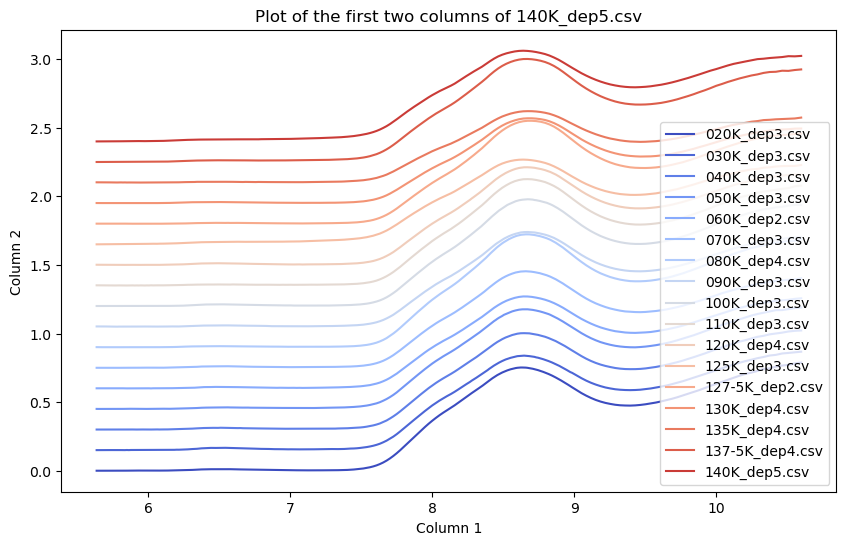

In [101]:
#    Plot figure 1
#--------------------------------------------------------

path = 'processed'
export_path='exports'

# glob processed files
temperatures = np.array(obs_all_data_143.temp)
depositions = np.array(obs_all_data_143.dep)

#print(np.array(temperatures))

#get list of required temps and deps
temp_dep = list(zip(temperatures, depositions))

filtered_temp_dep  =[]

for i in range(1, len(temp_dep)):
    # If the first 3 characters of the current element is not the same as the first character of the previous element
    if temp_dep[i][0] != temp_dep[i-1][0]:
        # Add the previous element to the filtered list
        filtered_temp_dep.append(temp_dep[i-1])
# Add the last element
filtered_temp_dep.append(temp_dep[-1])
#seperate out the temperatures and deps
filtered_temp = [t[0] for t in filtered_temp_dep]
filtered_dep = [d[1] for d in filtered_temp_dep]

print(len(filtered_temp))

#now create filtered df with only the values of interest
filtered_df = p[p['temp'].isin(filtered_temp) & p['dep'].isin(filtered_dep)]
print(filtered_df)

# And extract the peak positions Get the peak1 and peak2 values
peak1_values = filtered_df['peak1'].values
peak2_values = filtered_df['peak2'].values

print(len(peak1_values))

best_spectra = []

#now extract the bkgd subtracted datacurves for filtered data sets
for fil_temp_dep in filtered_temp_dep:
    #   adjust for file naming - i.e. add  0.5 K to 127.5 and 137.5 K
    temperature_str = str(fil_temp_dep[0])       
    temperature_str = temperature_str[:-2]
    if len(temperature_str) == 2:
    # Add a zero to the beginning
        temperature_str = '0' + temperature_str
    if temperature_str[-1] == "7":
    # add "-5"
        temperature_str += "-5"
    #add text 
    temperature_str +="K_dep"+str(fil_temp_dep[1])
    temperature_str  = temperature_str[:-1]+"csv"
    best_spectra.append(temperature_str)

print(len(best_spectra))

plt.figure(figsize=(10, 6))
# Define the colormap
cmap = plt.get_cmap('coolwarm')

# Define the offset for the waterfall plot
offset = 0

for i, file in enumerate (sorted(best_spectra)):
    # Construct the full file path
    file_path = os.path.join(export_path, file)    
    # Read the csv file into a dataframe
    df = pd.read_csv(file_path)    
    # Plot the first two columns of the dataframe
    photon_energy = WLtoE(df.iloc[:, 0])
    
    plt.plot(photon_energy, df.iloc[:, 2]  + offset, label=file, color=cmap(i / len(best_spectra)))
    
    # Increase the offset
    offset += 0.15
    
plt.title(f'Plot of the first two columns of {file}')
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.legend()
plt.show()


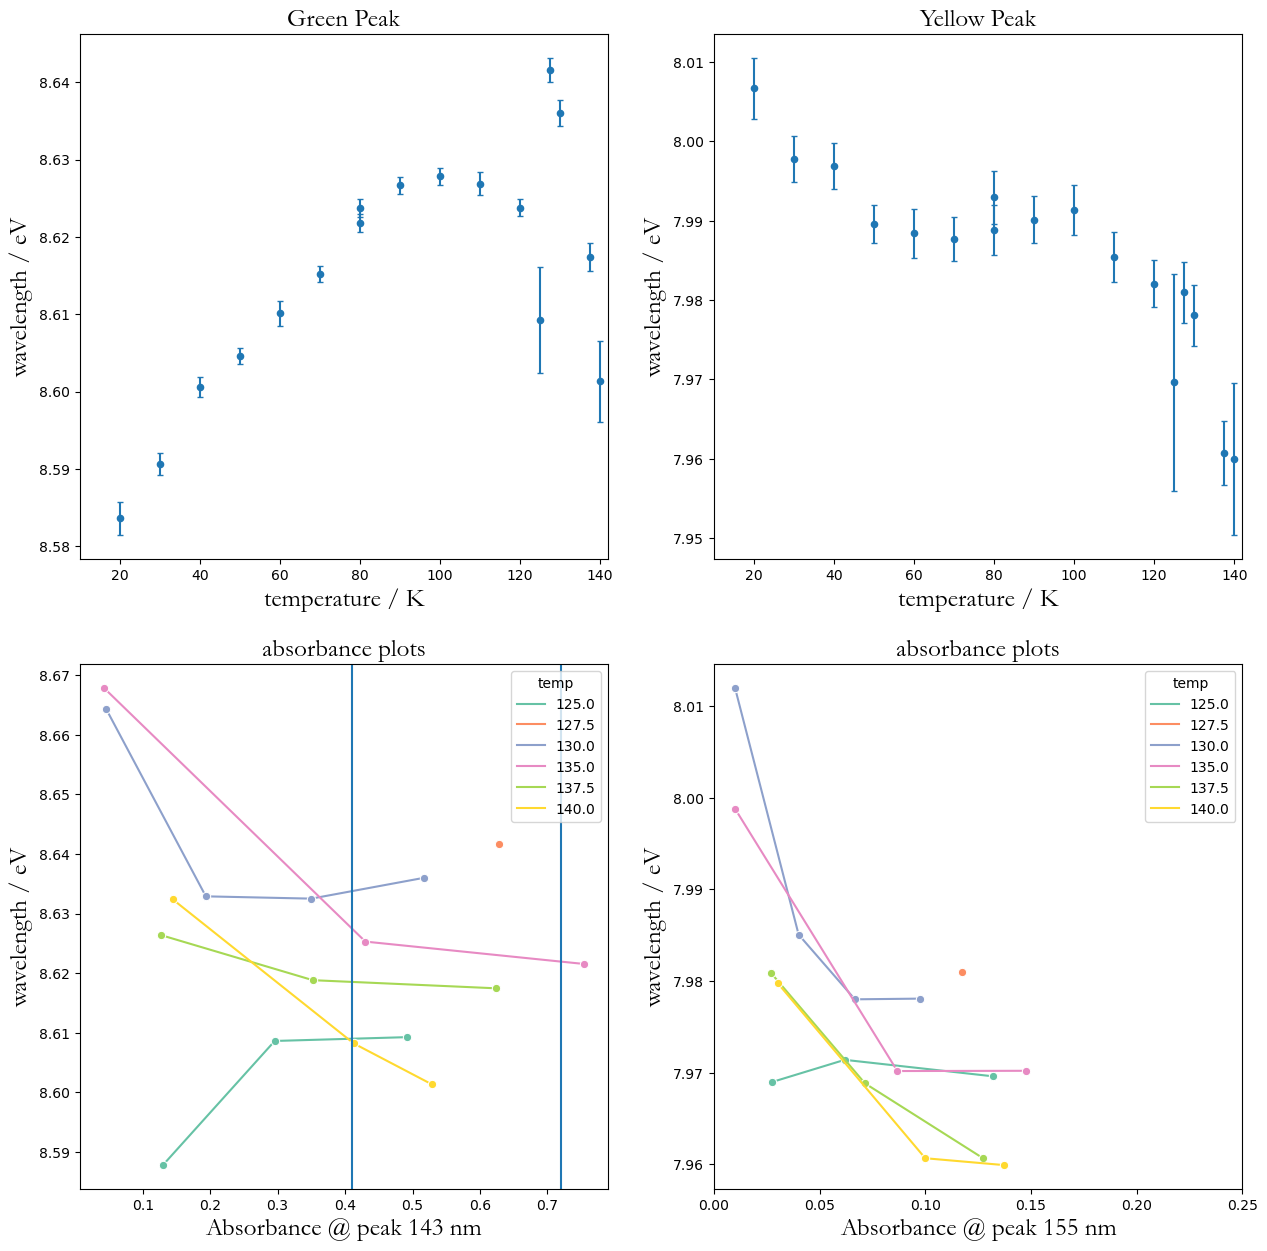

In [34]:
fig, axs = plt.subplots(2, 2, sharex=False, figsize=(15,15)) # I am making a 4 x 4 row x column grid
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.2)
       

p = pd.DataFrame(data, columns=['temp','dep',
                                'ab1','peak1','sig1','ab1_er','peak1_er','sig1_er',
                                'ab2','peak2','sig2','ab2_er','peak2_er','sig2_er',
                                'ab3','peak3','sig3','ab3_er','peak3_er','sig3_er',
                                'ab4','peak4','sig4','ab4_er','peak4_er','sig4_er'])

#fit_polynomial_same_temp(p, 'ab2', 'peak2', 'temp', 2)


plt.rcParams['errorbar.capsize']=2
#   144 nm peak
p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak1', yerr = 'peak1_er', ax=axs[0,0])
#   155 nm peak
p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak2', yerr = 'peak2_er',ax=axs[0,1])
#   115 nm peak
#p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak3', yerr = 'peak3_er',ax=axs[0])
#   190 nm peak
#p.loc[(p.ab1>0.47) & (p.ab1<0.71)].plot.scatter(x='temp',y='peak4', yerr = 'peak4_er',ax=axs[3])
axs[0,0].set_xlim(10,142)
axs[0,1].set_xlim(10,142)
#axs[0,0].set_ylim(143.1,144.3)
axs[0,0].set_title('Green Peak', family="garamond", fontsize=18)
axs[0,1].set_title('Yellow Peak', family="garamond", fontsize=18)
axs[0,0].set_xlabel('temperature / K', family="garamond", fontsize=18)
axs[0,1].set_xlabel('temperature / K', family="garamond", fontsize=18)
axs[0,1].set_ylabel('wavelength / eV', family="garamond", fontsize=18)
axs[0,0].set_ylabel('wavelength / eV', family="garamond", fontsize=18)


sns.lineplot(data=p.loc[p.temp>120], palette = "Set2", x='ab1',y='peak1', marker='o', hue='temp',  ax=axs[1,0])
#sns.lineplot(data=p, palette = "Set2", x='ab1',y='peak1', marker='o', hue='temp',  ax=axs[1,0])
#   155 nm peak
sns.lineplot(data=p.loc[p.temp>120], palette = "Set2", x='ab2',y='peak2', marker='o', hue='temp', ax=axs[1,1])
#sns.lineplot(data=p, palette = "Set2", x='ab2',y='peak2', marker='o', hue='temp', ax=axs[1,1])

axs[1,0].set_xlabel('Absorbance @ peak 143 nm', family="garamond", fontsize=18)
axs[1,0].set_ylabel('wavelength / eV', family="garamond", fontsize=18)
axs[1,0].set_title('absorbance plots', family="garamond", fontsize=18)
axs[1,1].set_xlabel('Absorbance @ peak 155 nm', family="garamond", fontsize=18)
axs[1,1].set_ylabel('wavelength / eV', family="garamond", fontsize=18)
axs[1,1].set_title('absorbance plots', family="garamond", fontsize=18)
axs[1,1].set_xlim(0.0,0.25)
#axs[1,1].set_ylim(155.0,157.1)

axs[1,0].axvline(x = 0.41,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1) 
axs[1,0].axvline(x = 0.72,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1) 
#axs[1,1].axvline(x = 0.12,    # Line on x = 2
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 
#axs[1,1].axvline(x = 0.18,    # Line on x = 2
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 


#plt.show()

fig.savefig('water_spont_peaks.png')

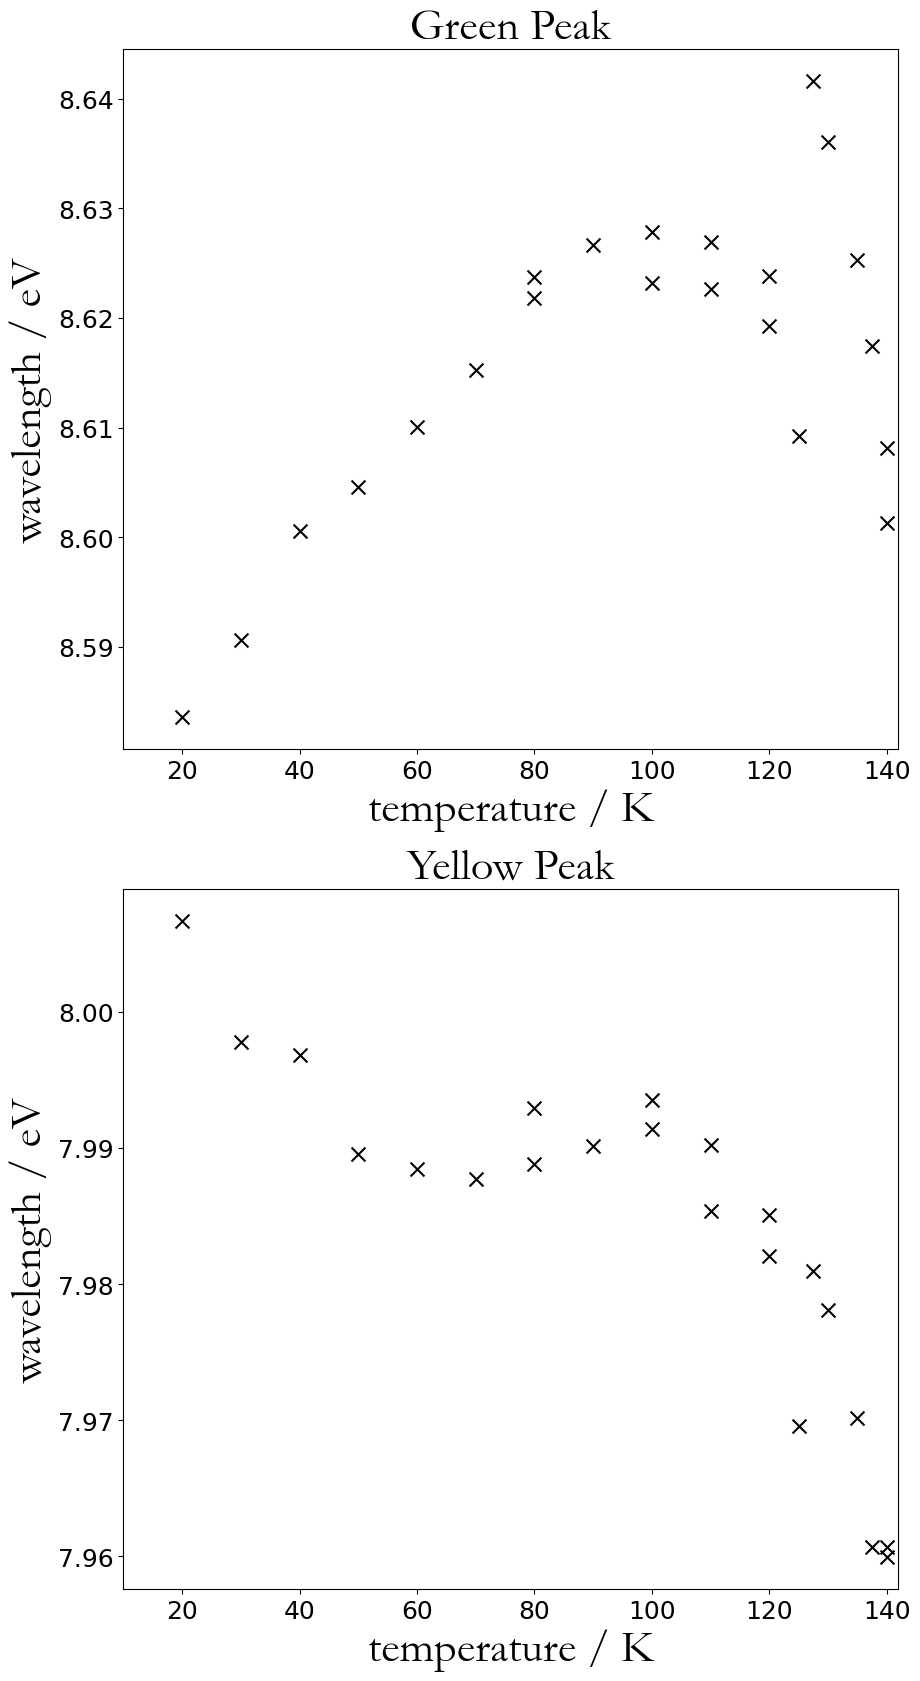

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 2x1 subplot
fig, axs = plt.subplots(2, 1, sharex=False, figsize=(10, 20))
fig.subplots_adjust(hspace=0.2)

# Read data from CSV files
p_143 = pd.read_csv('water_143 all positions for Gauss2.txt', delim_whitespace=True, header=0)
p_155 = pd.read_csv('water_155 all positions for Gauss2.txt', delim_whitespace=True, header=0)

# Rename columns if necessary
p_143.columns = ['temp', 'position']
p_155.columns = ['temp', 'position']

# Plot data on the respective axes
p_143.plot.scatter(x='temp', y='position', ax=axs[0], color='black', marker='x', s=100)
p_155.plot.scatter(x='temp', y='position', ax=axs[1], color='black', marker='x', s=100)

# Set x and y limits
axs[0].set_xlim(10, 142)
axs[1].set_xlim(10, 142)

# Set titles and labels
axs[0].set_title('Green Peak', family="garamond", fontsize=32)
axs[1].set_title('Yellow Peak', family="garamond", fontsize=32)
axs[0].set_xlabel('temperature / K', family="garamond", fontsize=32)
axs[1].set_xlabel('temperature / K', family="garamond", fontsize=32)
axs[0].set_ylabel('wavelength / eV', family="garamond", fontsize=32)
axs[1].set_ylabel('wavelength / eV', family="garamond", fontsize=32)
# Update tick label font size
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)

plt.show()


C:\Users\au302163\AppData\Local\Temp\ipykernel_14232\819562470.py:44: RankWarning: Polyfit may be poorly conditioned
  poly_data = fit_polynomial_same_temp(p, 'ab1', 'peak1', 'temp', 2)


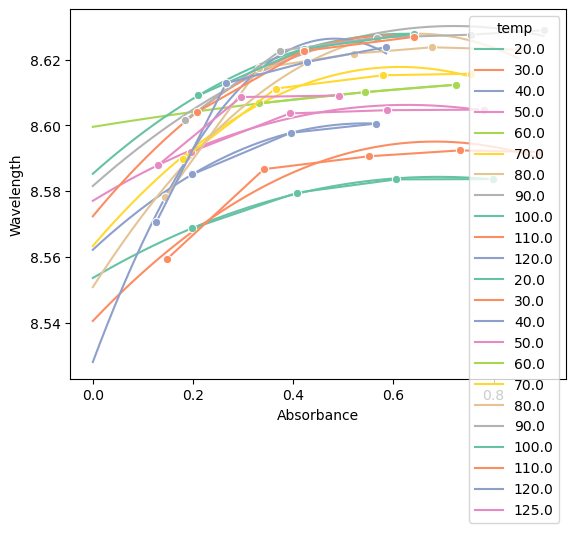

In [29]:
## To fit a polynomial to peak position data as a function of film thickenss(aka absorbance). 
## Aim is to get peak potision at zero absorbance

# define poltnomial function that auto scan through data in dataframe called "p"
def fit_polynomial_same_temp(df, x_col, y_col, temp_col, order):
    poly_data = pd.DataFrame()
    # Group the DataFrame by the temperature column and iterate over each group
    for temp, group in df.groupby(temp_col):
        
        # Extract the x and y data
        x_data = group[x_col]
        y_data = group[y_col]
        
        #print('xdata\n',x_data)
        #print('ydata\n',y_data)
        
        # Fit the polynomial
        coefficients = np.polyfit(x_data, y_data, order)

        # Create the polynomial function
        polynomial_func = np.poly1d(coefficients)
        
        # Print the polynomial function for this temperature
        #print(f"Polynomial function for {temp_col}={temp}:")
        #print(polynomial_func)
        #print("\n")
        
        # Generate x values for the plot
        x_plot = np.linspace(0, max(x_data), 400)

        # Compute y values for the plot
        y_plot = polynomial_func(x_plot)
        
        temp_data = pd.DataFrame({
            'x_plot': x_plot,
            'y_plot': y_plot,
            'temp': temp
        })
        poly_data = pd.concat([poly_data, temp_data])
        

    return poly_data

poly_data = fit_polynomial_same_temp(p, 'ab1', 'peak1', 'temp', 2)

#print(poly_data.loc[poly_data.temp<127])

#fig, axs = plt.subplots(2, 1, sharex=False, figsize=(4,6)) # I am making a 2 x 1 row x column grid
#fig.subplots_adjust(hspace=0.4)

poly_data_reset = poly_data.reset_index()
sns.lineplot(data=poly_data_reset.loc[poly_data_reset.temp<125], palette = "Set2",x='x_plot', y='y_plot',hue='temp')
sns.lineplot(data=p.loc[p.temp<127], palette = "Set2", x='ab1',y='peak1', marker='o', hue='temp')

# Set x and y axis limits
#plt.xlim(0, 0.27)
#plt.ylim(155, 156.5)

# Set x and y axis labels
plt.xlabel('Absorbance')
plt.ylabel('Wavelength')

# Show the plot
plt.show()



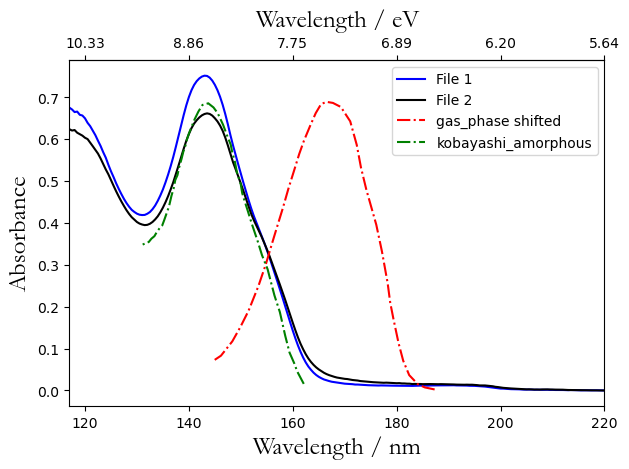

In [62]:
#plot selected spectra
Temp_to_plot = ('137-5K') #e.g., 100K, 020K  - alwyas three digits (no space!) You can plot two different temperatures
Dep_to_plot = ('4') #e.g., '2' just number
gas_shift = 0#23.5 # in nm
kobayashi_shift = 0 # in nm

File_name1 = ('ter_'+(Temp_to_plot)+'_dep'+(Dep_to_plot))

file1_to_plot = pd.read_csv('exports/'+File_name1+'.csv',header=[0])#,delimiter=r"\s+")

Temp_to_plot = ('140K') #e.g., 100K, 020K  - alwyas three digits (no space!) You can plot two different temperatures
Dep_to_plot = ('5') #e.g., '2' just number

File_name2 = ('ter_'+(Temp_to_plot)+'_dep'+(Dep_to_plot))

file2_to_plot = pd.read_csv('exports/'+File_name2+'.csv',header=[0])#,delimiter=r"\s+")


water_gas_phase = pd.read_csv('water_gas_phase.csv', header= [0])
water_kobayashi = pd.read_csv('water_kobayashi.csv', header= [0])

water_gas_phase['wavelength'] = 1239.8/water_gas_phase['x']
water_gas_phase['wavelength_shift'] = water_gas_phase['wavelength'] - gas_shift
water_gas_phase['absorbance'] = (water_gas_phase.iloc[:, 1]) / 7.5

water_kobayashi['wavelength'] = 1239.8/water_kobayashi['x']
water_kobayashi['wavelength_shift'] = water_kobayashi['wavelength'] - kobayashi_shift
water_kobayashi['absorbance'] = (water_kobayashi.iloc[:, 1]) / 4

# Function to prevent zero values in an array
def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if abs(entry) < float_info.epsilon:
            corrected_array[i] = float_info.epsilon
    
    return corrected_array

# Converting wavelength (nm) to energy (eV)
def WLtoE(wl):
    # Prevent division by zero error
    wl = preventDivisionByZero(wl)

    # E = h*c/wl            
    h = constants.h         # Planck constant
    c = constants.c         # Speed of light
    J_eV = constants.e      # Joule-electronvolt relationship
    
    wl_nm = wl * 10**(-9)   # convert wl from nm to m
    E_J = (h*c) / wl_nm     # energy in units of J
    E_eV = E_J / J_eV       # energy in units of eV
    
    return E_eV  

# Converting energy (eV) to wavelength (nm)
def EtoWL(E):
    # Prevent division by zero error
    E = preventDivisionByZero(E)
    
    # Calculates the wavelength in nm
    return constants.h * constants.c / (constants.e * E) * 10**9

fig, ax1 = plt.subplots()

ax1.plot(file1_to_plot['wavelength'], file1_to_plot['absorbance_bk'],'b-', label='File 1')
ax1.plot(file2_to_plot['wavelength'], 1.00*file2_to_plot['absorbance_bk'],'k-', label='File 2')
ax1.plot(water_gas_phase['wavelength_shift'], water_gas_phase['absorbance'], 'r-.', label='gas_phase shifted')
ax1.plot(water_kobayashi['wavelength_shift'], water_kobayashi['absorbance'], 'g-.', label='kobayashi_amorphous')

ax1.set_ylabel('Absorbance',family="garamond", fontsize=18)
ax1.set_xlabel('Wavelength / nm',family="garamond", fontsize=18)
ax1.legend()
#plt.ylim(0,0.8)
ax1.set_xlim(117,220)
#ax1.axvline(x = 143,    
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 
#ax1.axvline(x = 155,    
#           ymin = 0, # Bottom of the plot
#           ymax = 1) 

# Create the second x-axis on which the energy in eV will be displayed
ax2 = ax1.secondary_xaxis('top', functions=(WLtoE, EtoWL))
ax2.set_xlabel('Wavelength / eV',family="garamond", fontsize=18, labelpad=7)

# Get ticks from ax1 (wavelengths)
wl_ticks = ax1.get_xticks()
wl_ticks = preventDivisionByZero(wl_ticks)

# Based on the ticks from ax1 (wavelengths), calculate the corresponding energies in eV
E_ticks = WLtoE(wl_ticks)

# Set the ticks for ax2 (Energy)
ax2.set_xticks(E_ticks)

# Allow for two decimal places on ax2 (Energy)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


#ax1.legend()
#ax1.set_title((Temp_to_plot)+'_dep'+(Dep_to_plot),family="garamond", fontsize=22)
plt.tight_layout()
plt.show()

print(os.getcwd())
#os.chdir('..')
print(os.getcwd())

In [ ]:
#   plot spont and nonspont Gauss peak as function of absorbance
#----------------------------------------------------------------------
p = pd.DataFrame(data, columns=['temp','dep',
                                'ab1','peak1','sig1','ab1_er','peak1_er','sig1_er',
                                'ab2','peak2','sig2','ab2_er','peak2_er','sig2_er',
                                'ab3','peak3','sig3','ab3_er','peak3_er','sig3_er',
                                'ab4','peak4','sig4','ab4_er','peak4_er','sig4_er'])

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(4,6)) # I am making a 2 x 1 row x column grid
fig.subplots_adjust(hspace=0.4)

#   144 nm peak
sns.lineplot(data=p.loc[p.temp>=125], x='dep',y='ab4', palette = "Set2", marker='o', hue='temp', ax=axs[0])
#   155 nm peak
sns.lineplot(data=p.loc[p.temp>=125], x='dep',y='ab1', palette = "Set2", marker='o', hue='temp', ax=axs[1])

axs[0].set_xlabel('deposition')
axs[0].set_title('Is peak 4 a contamination?')
#axs[1].set_title('Spont temps - 155 nm peak (>=125 K)')
#axs[1].set_xlabel('deposition')

plt.show()